## Stark Effect In Measured Grav-z Distributions

In [119]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from astroquery.sdss import SDSS
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from stark import sdss
from stark import utils

plt.style.use('stefan.mplstyle')

In [120]:
catalog = pd.read_csv('../data/raw/Arseneau_2024.csv')
catalog = catalog.drop_duplicates(subset=['wd_source_id'])
subset = catalog.query("snr > 15 & R_chance_align < 0.1 & wd_rv_from != 'falcon'")

## Compute Theoretical Grav-z

In [121]:
from stark.interpolator import interpolator as int
from tqdm import tqdm

def get_theoretical_vg(table):
    gravzs = []
    for i, row in tqdm(table.iterrows(), total=table.shape[0]):
        radius, e_radius, teff, e_teff, logg, e_logg, result = sdss.fit_radius(row, int.LaPlataBase, **{'layer': 'Hrich'})
        mass = int.LaPlataBase(['Gaia_G'], layer='Hrich').radiustomass(radius, teff)
        vg = (6.67e-11 * mass * 1.989e30) / (3e8 * radius * 6.957e8) * 1e-3
        gravzs.append(vg)
    gravzs = np.array(gravzs)
    return gravzs

gravzs = get_theoretical_vg(subset)

100%|██████████| 173/173 [01:14<00:00,  2.33it/s]


## Fitting Four Balmer Lines

In [122]:
sp = sdss.SDSSHandler(subset, 'wd_rv_from', '../data/raw/sdss5', '../data/raw/apo')
#abgd_result = sp.analyze_table('../data/processed/arseneau2024/Habgd_v2_voigt.json', lines = ['a','b','g','d'], resolution = 1, from_cache=True)

100%|██████████| 173/173 [57:24<00:00, 19.91s/it] 


In [123]:
import json
with open('../data/processed/arseneau2024/Habgd_v2.json') as json_file:
    abgd_result = json.load(json_file)

In [124]:
def process_json(result, subset):
    result = utils.tabularize(result)
    result = result.drop(columns=['reference_window', 'reference_rv', 'reference_erv', 'reference_teff', 
                        'reference_logg', 'differentials', 'significance', 'e_teff', 
                        'logg', 'e_logg'])
    result.file = result.file.astype(np.int64)
    catdata = subset.merge(result, left_on = 'wd_source_id', right_on='file')

    df_with_mask = utils.apply_rules(catdata, sigma = 3, rv_over_err = 0.0001, chisqr = 5)
    df_masked = utils.apply_mask(df_with_mask, rows = ['rvs', 'e_rvs', 'redchisqr', 'teff'])

    windows = np.array(df_masked.iloc[0].windows.tolist())[1:]
    teffs = np.nanmean(np.array(df_masked.teff.tolist()), axis=1)
    gravzs = np.array((df_masked.rvs - df_masked.radial_velocity).tolist())
    e_gravzs = np.array(((df_masked.e_rvs**2 + df_masked.radial_velocity_error**2)**0.5).tolist())
    return windows, teffs, gravzs, e_gravzs

def split_teff(bounds, teffs, gravzs, e_gravzs):
    temp_bn_to_range = lambda n: (bounds[n-1], bounds[n]) if (n != len(bounds) and (n != 0)) else ((bounds[n-1], np.infty) if n == len(bounds) else (-np.infty, bounds[n]))
    temp_bn_to_center = lambda n: np.mean(temp_bn_to_range(n))

    teff_bin = np.digitize(teffs, bounds)
    high_mask = (teff_bin == 3)
    low_mask = (teff_bin == 1)
    return gravzs[high_mask,:], gravzs[low_mask,:], e_gravzs[high_mask,:], e_gravzs[low_mask,:]

def analyze_distribution(gravzs, e_gravzs):
    mean = np.array([np.nanmean(gravzs[:,i+1]) for i in range(gravzs.shape[1]-1)])
    def error(gravzs):
        stderr = []
        for i in range(gravzs.shape[1]-1):
            gravzs_range = gravzs[:,i+1]
            gravzs_nan = gravzs_range[~np.isnan(gravzs_range)]
            stderr.append((1 / len(gravzs_nan)) * np.sqrt(np.sum(gravzs_nan**2)))
        return np.array(stderr)

    stderr = error(gravzs)
    return mean, stderr

abgd_windows, abgd_teffs, abgd_gravzs, abgd_e_gravzs = process_json(abgd_result, subset)
abgd_mean, abgd_std = analyze_distribution(abgd_gravzs, abgd_e_gravzs)

temp_bin_edges = [0, 12000, 16000]
hot_abgd_gravzs, cool_abgd_gravzs, hot_abgd_e_gravzs, cool_abgd_e_gravzs = split_teff(temp_bin_edges, abgd_teffs, abgd_gravzs, abgd_e_gravzs)
hot_abgd_mean, hot_abgd_std = analyze_distribution(hot_abgd_gravzs, hot_abgd_e_gravzs)
cool_abgd_mean, cool_abgd_std = analyze_distribution(cool_abgd_gravzs, cool_abgd_e_gravzs)

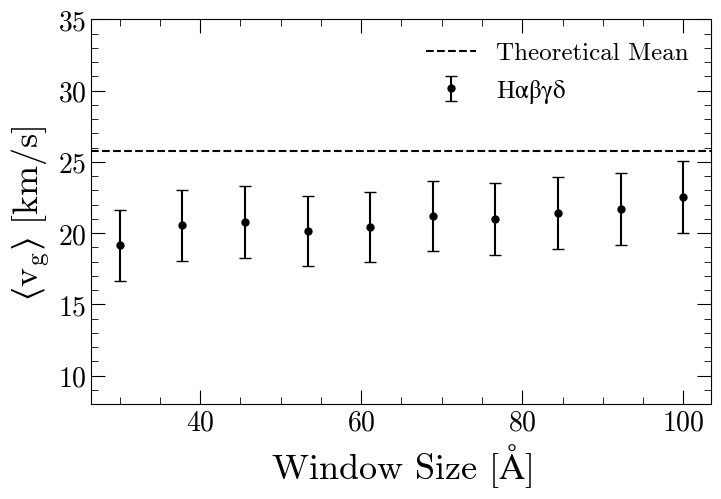

In [125]:
plt.figure(figsize=(8,5))
plt.errorbar(abgd_windows, abgd_mean, yerr = abgd_std, fmt = 'o', c = 'k', capsize = 4, label=r'H$\alpha\beta\gamma\delta$')
plt.axhline(y=np.nanmean(gravzs), c = 'k', ls = '--', label='Theoretical Mean')
#plt.axhline(y=31.47, c = 'k', ls = '--', label='Falcon+2010')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_g \rangle$ $[km/s]$')
plt.ylim(8, 35)
plt.legend(framealpha=0)

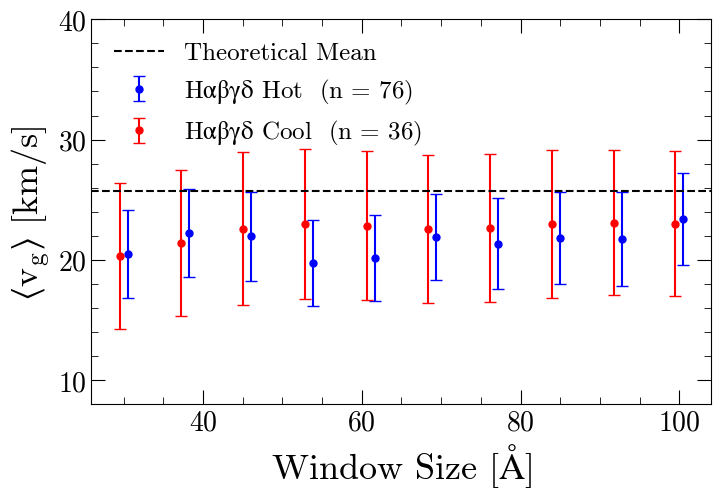

In [126]:
plt.figure(figsize=(8,5))
plt.errorbar(abgd_windows+0.5, hot_abgd_mean, yerr = hot_abgd_std, fmt = 'o', c = 'blue', capsize = 4, label=rf'H$\alpha\beta\gamma\delta$ Hot  (n = {hot_abgd_gravzs.shape[0]})')
plt.errorbar(abgd_windows-0.5, cool_abgd_mean, yerr = cool_abgd_std, fmt = 'o', c = 'red', capsize = 4, label=rf'H$\alpha\beta\gamma\delta$ Cool  (n = {cool_abgd_gravzs.shape[0]})')
plt.axhline(y=np.nanmean(gravzs), c = 'k', ls = '--', label='Theoretical Mean')
#plt.axhline(y=31.47, c = 'k', ls = '--', label='Falcon+2010')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_g \rangle$ $[km/s]$')
plt.ylim(8, 40)
plt.legend(framealpha=0)

## Fitting 2 Balmer Lines

In [110]:
sp = sdss.SDSSHandler(subset, 'wd_rv_from', '../data/raw/sdss5', '../data/raw/apo')
ab_result = sp.analyze_table('../data/processed/arseneau2024/Hab_v2_voigt.json', lines = ['a','b'], resolution = 1, from_cache=False)

 17%|█▋        | 29/173 [07:47<40:13, 16.76s/it]

In [111]:
with open('../data/processed/arseneau2024/Hab_v2.json') as json_file:
    ab_result = json.load(json_file)

In [112]:
ab_windows, ab_teffs, ab_gravzs, ab_e_gravzs = process_json(ab_result, subset)
ab_mean, ab_std = analyze_distribution(ab_gravzs, ab_e_gravzs)

hot_ab_gravzs, cool_ab_gravzs, hot_ab_e_gravzs, cool_ab_e_gravzs = split_teff(temp_bin_edges, ab_teffs, ab_gravzs, ab_e_gravzs)
hot_ab_mean, hot_ab_std = analyze_distribution(hot_ab_gravzs, hot_abgd_e_gravzs)
cool_ab_mean, cool_ab_std = analyze_distribution(cool_ab_gravzs, cool_ab_e_gravzs)

/tmp/ipykernel_3321/2412755350.py:13: RuntimeWarning: Mean of empty slice
  teffs = np.nanmean(np.array(df_masked.teff.tolist()), axis=1)


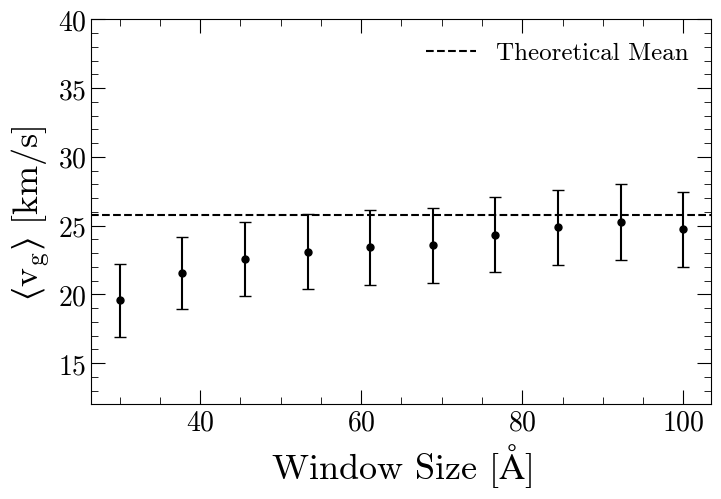

In [113]:
plt.figure(figsize=(8,5))
plt.errorbar(ab_windows, ab_mean, yerr = ab_std, fmt = 'o', c = 'k', capsize = 4)
plt.axhline(y=np.nanmean(gravzs), c = 'k', ls = '--', label='Theoretical Mean')
#plt.axhline(y=31.47, c = 'k', ls = '--', label='Falcon+2010')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_g \rangle$ $[km/s]$')
plt.ylim(12, 40)
plt.legend(framealpha=0)

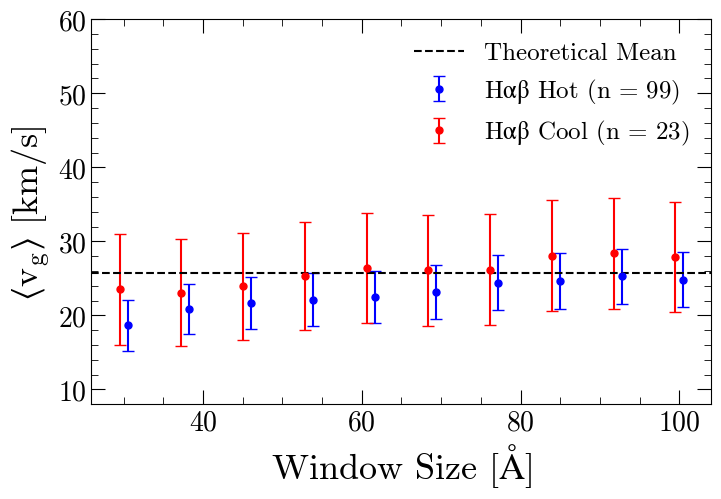

In [114]:
plt.figure(figsize=(8,5))
plt.errorbar(ab_windows+0.5, hot_ab_mean, yerr = hot_ab_std, fmt = 'o', c = 'blue', capsize = 4, label=rf'H$\alpha\beta$ Hot (n = {hot_ab_gravzs.shape[0]})')
plt.errorbar(ab_windows-0.5, cool_ab_mean, yerr = cool_ab_std, fmt = 'o', c = 'red', capsize = 4, label=rf'H$\alpha\beta$ Cool (n = {cool_ab_gravzs.shape[0]})')
plt.axhline(y=np.nanmean(gravzs), c = 'k', ls = '--', label='Theoretical Mean')
#plt.axhline(y=31.47, c = 'k', ls = '--', label='Falcon+2010')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_g \rangle$ $[km/s]$')
plt.ylim(8, 60)
plt.legend(framealpha=0)

## Comparison

(10.0, 37.0)

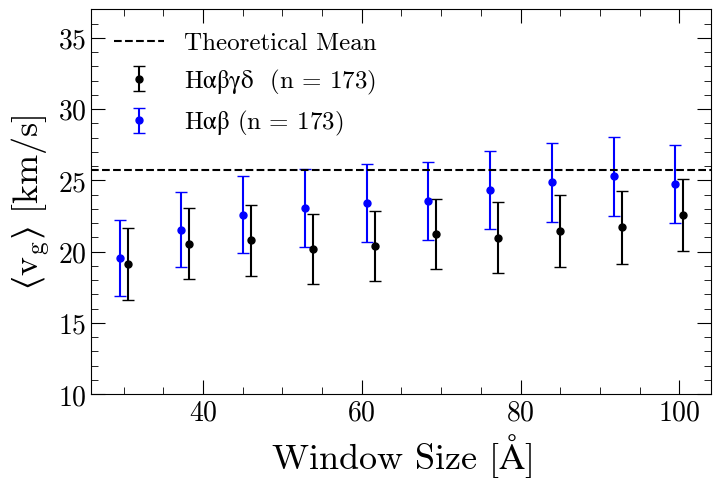

In [115]:
plt.figure(figsize=(8,5))
plt.errorbar(abgd_windows+0.5, abgd_mean, yerr=abgd_std, fmt='o', color = 'k', capsize = 4,
             label=rf'$H\alpha\beta\gamma\delta$  (n = {abgd_gravzs.shape[0]})')
plt.errorbar(ab_windows-0.5, ab_mean, yerr=ab_std, fmt='o', c = 'blue', capsize = 4,
             label=rf'$H\alpha\beta$ (n = {ab_gravzs.shape[0]})')
plt.axhline(y=np.nanmean(gravzs), c = 'k', ls = '--', label='Theoretical Mean')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_g \rangle$ $[km/s]$')
plt.legend(framealpha=0)
plt.ylim(10, 37)

## Stark Effect

In [116]:
ab_stark = ab_gravzs - gravzs.reshape((gravzs.shape[0],1))
abgd_stark = abgd_gravzs - gravzs.reshape((gravzs.shape[0],1))

In [117]:
ab_mean, ab_std = analyze_distribution(ab_stark, ab_e_gravzs)
abgd_mean, abgd_std = analyze_distribution(abgd_stark, abgd_e_gravzs)

(-15.0, 15.0)

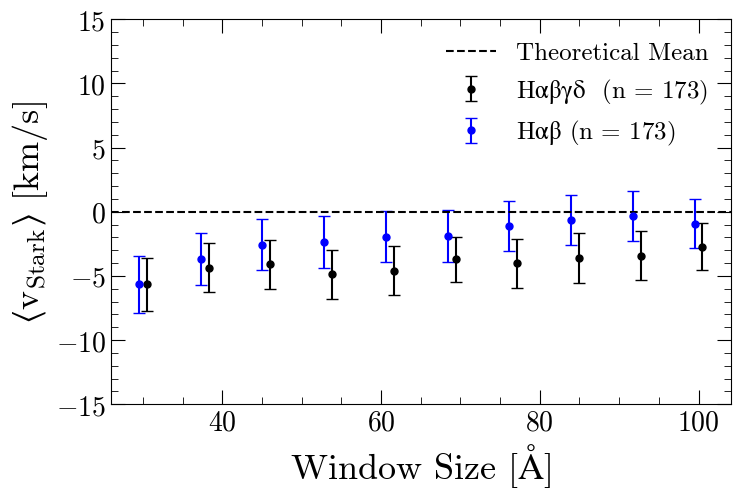

In [118]:
plt.figure(figsize=(8,5))
plt.errorbar(abgd_windows+0.5, abgd_mean, yerr=abgd_std, fmt='o', color = 'k', capsize = 4,
             label=rf'$H\alpha\beta\gamma\delta$  (n = {abgd_gravzs.shape[0]})')
plt.errorbar(ab_windows-0.5, ab_mean, yerr=ab_std, fmt='o', c = 'blue', capsize = 4,
             label=rf'$H\alpha\beta$ (n = {ab_gravzs.shape[0]})')
plt.axhline(y=0, c = 'k', ls = '--', label='Theoretical Mean')
plt.xlabel(r'Window Size $[\AA]$')
plt.ylabel(r'$\langle v_{Stark} \rangle$ $[km/s]$')
plt.legend(framealpha=0)
plt.ylim(-15, 15)